<a href="https://colab.research.google.com/gist/qbeer/74d064ee596744ff4e9c9716922f471b/hw11_no_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 11.

* Running the models may take minutes. This HW takes ~30 min to complete in computational time, so make sure you don't start it 1 hour before it is due.

* Tasks 2-4. should be done using the `sklearn` library, the last is a pure TensorFlow ([Keras is part of TensorFlow](https://github.com/keras-team/keras/releases#:~:text=since%20this%20release-,Keras%202.2.,well%20as%20Theano%20and%20CNTK)) example.

  * Never do `import keras` it only references `tf.keras` since version `2.4.0`!

* The example notebook was run in Google COLAB without any package installation. I advise you to use Google COLAB with a GPU instance for the last task.

## 1. Load the CIFAR 10 dataset from the `tf.keras.datasets` API and train a `LogisticRegression` model on the dataset and predict all test outcomes with the `sklearn` API

* Create an image grid visualization of randomly selected images (9, 16) with labels.
* Preprocess the dataset for `sklearn`, scale [0-1], and also flatten each example to a vector.
* Use the `multi_class='multinomial'` option, describe what it means.
* Plot the ROC curves and AUC scores on the same figure.
* Calculate the accuracy of the classifier on the test set.

* Make your life easier - time is precious - and run all the algorithms with multiprocessing.

Hint:

* `from sklearn.preprocessing import LabelBinarizer` might be useful for you.




In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn

import os
import sys
import pathlib
import glob

import random as random # :)

import multiprocessing
print("My core number: {}".format(multiprocessing.cpu_count()))

import tensorflow as tf

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

tf.compat.v1.disable_eager_execution()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(tf.__version__)
print(dir(tf.feature_column))

gpus = tf.config.experimental.list_physical_devices(device_type="GPU")

My core number: 2
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13730716072095263803
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2707363912182198945
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]
2.7.0
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'bucketized_column', 'categorical_column_with_hash_bucket', 'categorical_column_with_identity', 'categorical_column_with_vocabulary_file', 'categorical_column_with_vocabulary_list', 'crossed_column', 'embedding_column', 'indicator_column', 'make_parse_example_spec', 'numeric_column', 'sequence_categorical_column_with_hash_bucket', 'sequence_categorical_column_with_identity', 'sequence_categorical_column_with_vocabulary_file', 'sequence_categori

In [2]:
coded = [0,1,2,3,4,5,6,7,8,9]
types = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def plot_grid(trn,trgt, nrws = 4, ncls = 4, mul = 1):
  #lets see what are these!
  #find 16 indices to be pulled from the data...
  ncols, nrows = nrws,ncls
  n = ncols * nrows
  random_indexes = random.sample(list(np.arange(len(trn))), n)
  random_samples = trn[random_indexes]
  random_targets = trgt[random_indexes]

  #print(random_samples)

  fig, axes = plt.subplots(ncols,nrows, figsize=(ncols*3,nrows*3))
  for i in range(len(axes)):
    for j in range(len(axes[i])):
      axes[i,j].set_title("This is a(n)\n{0}!".format(types[random_targets[i*len(axes[i]) + j][0]]), fontsize=24)
      axes[i,j].imshow(np.array(random_samples[i*len(axes[i]) + j] * mul, dtype=np.uint8))
      axes[i,j].set_axis_off()


  fig.tight_layout()
  plt.show()

X train shape 	  (50000, 32, 32, 3) 
Y train shape 	 (50000, 1) 

X test shape 	 (10000, 32, 32, 3) 
Y test shape 	 (10000, 1)


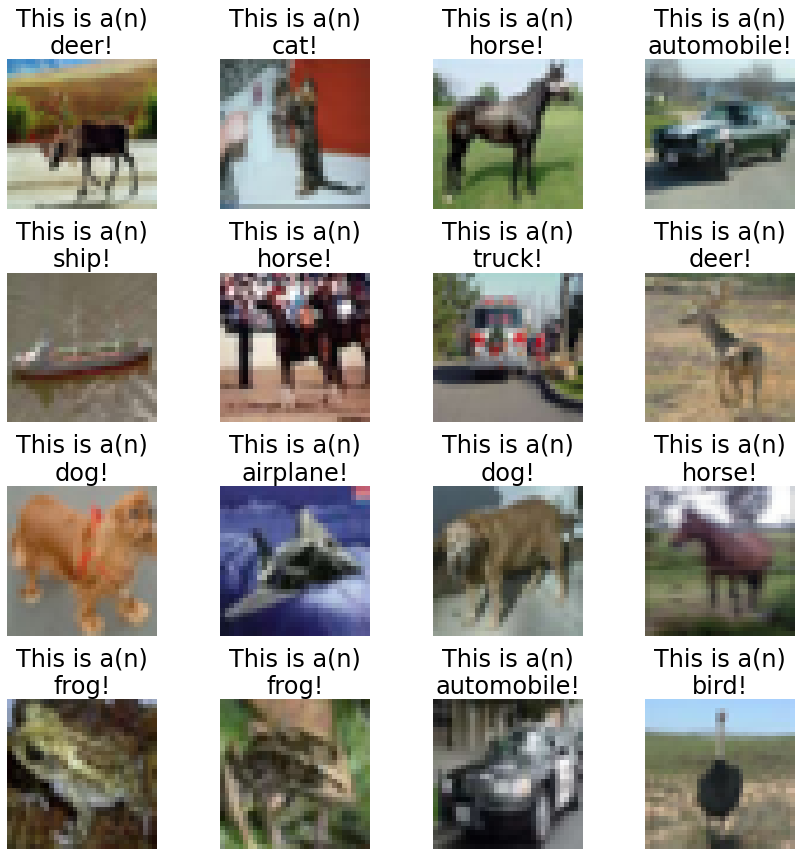

In [3]:
#getting the dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("X train shape \t ", X_train.shape,
      "\nY train shape \t", y_train.shape,
      "\n\nX test shape \t", X_test.shape,
      "\nY test shape \t", y_test.shape)

plot_grid(X_train, y_train)

#flatten here   Found array with dim 4.
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3]) / 255
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2] * X_test.shape[3]) / 255


In [4]:
def ROC_curves(test,predict,predict_proba):
  print("Vals: found", np.unique(predict, return_counts=True))

  one_hot_encoded1 = np.array(pd.get_dummies(test.flatten()))
  one_hot_encoded2 = np.array(pd.get_dummies(predict.flatten()))


  fig,ax=plt.subplots(1,1,figsize=(10,10))

  for i in range(10):
      fpr, tpr, thresholds = metrics.roc_curve(one_hot_encoded1[:,i], predict_proba[:,i])
      accuracy = metrics.accuracy_score(one_hot_encoded1[:,i], one_hot_encoded2[:,i])
      auc = metrics.auc(fpr, tpr)
      lbl = types[i] + ", {0:.1f}%,\n AUC: {1:.3f}".format(accuracy*100, auc)   
      ax.plot(fpr,tpr, label=lbl)

  ax.plot(np.linspace(-0.1,1.1,100),np.linspace(-0.1,1.1,100),"--c")


  ax.set_title("Multiclass ROC", fontsize=26)
  ax.set_xlabel("False positive rates", fontsize=22)
  ax.set_ylabel("True positive rates", fontsize=22)
  ax.grid()
  ax.tick_params(axis="both", labelsize=22)
  ax.legend(loc="best", fontsize=13)

  ax.set_xlim(-0.1,1.1)
  ax.set_ylim(-0.1,1.1)

  fig.tight_layout()

  plt.show()

So, as it seems like, the multiclass = "Multinomial" means that it just extends it to multiple classes, that are independent from ech other.(want to find independent variable for each class)

In [25]:
#train it
LogResPred = LogisticRegression(n_jobs=2,multi_class='multinomial').fit(X_train,y_train.flatten())
y_pred = LogResPred.predict(X_test)

Vals: found (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([1094, 1046,  863,  814,  810, 1084, 1158,  957, 1114, 1060]))


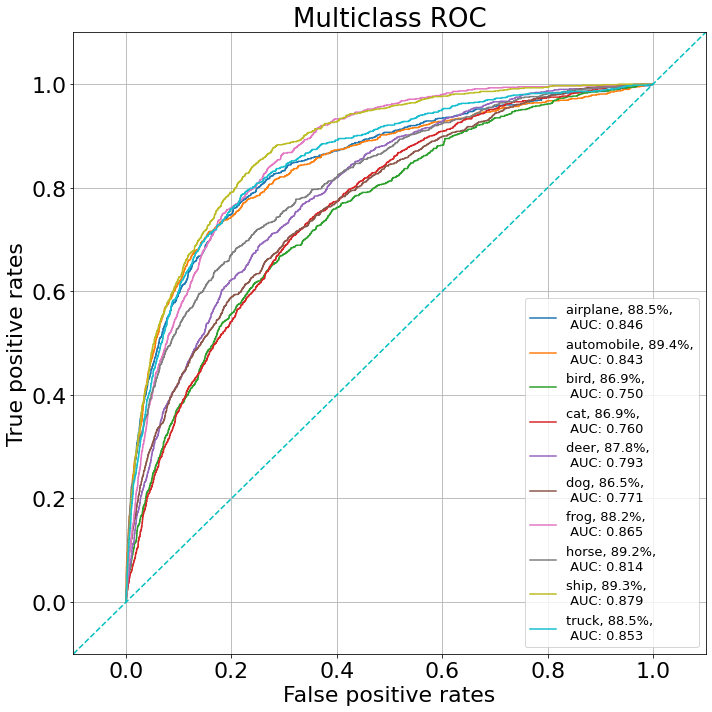

In [57]:
print("Vals: found", np.unique(y_pred, return_counts=True))

one_hot_encoded1 = np.array(pd.get_dummies(y_test.flatten()))
one_hot_encoded2 = np.array(pd.get_dummies(y_pred.flatten()))
y_pred_proba = LogResPred.predict_proba(X_test)


fig,ax=plt.subplots(1,1,figsize=(10,10))

for i in range(10):
    fpr, tpr, thresholds = metrics.roc_curve(one_hot_encoded1[:,i], y_pred_proba[:,i])
    accuracy = metrics.accuracy_score(one_hot_encoded1[:,i], one_hot_encoded2[:,i])
    auc = metrics.auc(fpr, tpr)
    lbl = types[i] + ", {0:.1f}%,\n AUC: {1:.3f}".format(accuracy*100, auc)   
    ax.plot(fpr,tpr, label=lbl)

ax.plot(np.linspace(-0.1,1.1,100),np.linspace(-0.1,1.1,100),"--c")


ax.set_title("Multiclass ROC", fontsize=26)
ax.set_xlabel("False positive rates", fontsize=22)
ax.set_ylabel("True positive rates", fontsize=22)
ax.grid()
ax.tick_params(axis="both", labelsize=22)
ax.legend(loc="best", fontsize=13)

ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)

fig.tight_layout()

plt.show()

## 2. Train an `SGDClassifier` regression model on the dataset and predict all the test outcomes with the `sklearn` API. 

* Select the appropiate loss for this task, explain what this means.
* Time is precious, run multiple jobs at the same time.
* Plot the ROC curves and AUC scores on the same figure for the test set.
* Calculate the accuracy of the classifier.
* Why is this worse than the previous model?
* Describe the above model with your own words, how is it different than the logistic regression model?



In [58]:
from sklearn.linear_model import SGDClassifier

After reading, the 'modified huber' is an SVC with gamma = 2 that is a bit modified for sklearn. Using 'log' gives a logistic regression. But what is 'hinge'? This is used when someone has a lot of data that needs to be fitted, minimazes loss with the distribution of the data. With this, partial_fit is possible and batches of data could be used.

`NOTE`: i won't use another log. res. model... (don't see the fun in that)

In [69]:
SGDC = SGDClassifier(n_jobs = 2, loss='modified_huber')
SGDC.fit(X_train, y_train.flatten())

SGDClassifier(loss='modified_huber', n_jobs=2)

In [70]:
y_pred2 = SGDC.predict(X_test)
y_pred_proba2 = SGDC.predict_proba(X_test)
print(y_pred_proba2.shape)

(10000, 10)


Vals: found (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([ 532, 1189,  148,   99,  108,  663,  175, 4630, 2402,   54]))


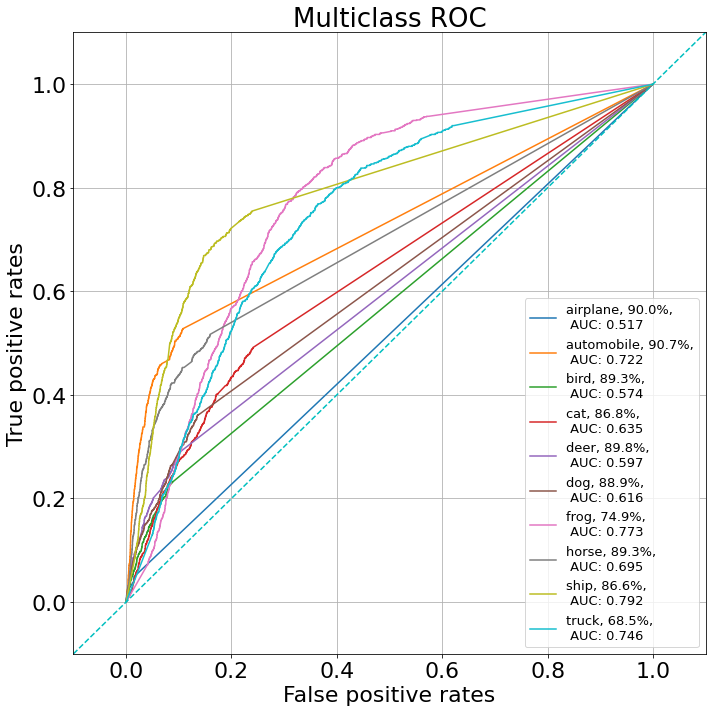

In [71]:
print("Vals: found", np.unique(y_pred, return_counts=True))

one_hot_encoded1 = np.array(pd.get_dummies(y_test.flatten()))
one_hot_encoded2 = np.array(pd.get_dummies(y_pred2.flatten()))


fig,ax=plt.subplots(1,1,figsize=(10,10))

for i in range(10):
    fpr, tpr, thresholds = metrics.roc_curve(one_hot_encoded1[:,i], y_pred_proba2[:,i])
    accuracy = metrics.accuracy_score(one_hot_encoded1[:,i], one_hot_encoded2[:,i])
    auc = metrics.auc(fpr, tpr)
    lbl = types[i] + ", {0:.1f}%,\n AUC: {1:.3f}".format(accuracy*100, auc)   
    ax.plot(fpr,tpr, label=lbl)

ax.plot(np.linspace(-0.1,1.1,100),np.linspace(-0.1,1.1,100),"--c")


ax.set_title("Multiclass ROC", fontsize=26)
ax.set_xlabel("False positive rates", fontsize=22)
ax.set_ylabel("True positive rates", fontsize=22)
ax.grid()
ax.tick_params(axis="both", labelsize=22)
ax.legend(loc="best", fontsize=13)

ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)

fig.tight_layout()

plt.show()

The AUC (Area Under Curve) is flattened and is generally has a lower accuracy.

## 3. Train a RandomForest classifier

* Plot the ROC curve with AUC scores on the test set.
* Calculate accuracy of the classifier on the test set.
* Time is precious, run multiple jobs at the same time.



In [72]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
#if i dont give it anything, the max depth is the number of features, meaning it will grow fully and will give exact or strange results
RFC = RandomForestClassifier(n_jobs=2, max_depth=32*32) 
RFC.fit(X_train, y_train.flatten())

RandomForestClassifier(max_depth=1024, n_jobs=2)

(10000,) (10000, 10)
Vals: found (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([1047, 1060,  892,  830,  970,  932, 1191,  889, 1040, 1149]))


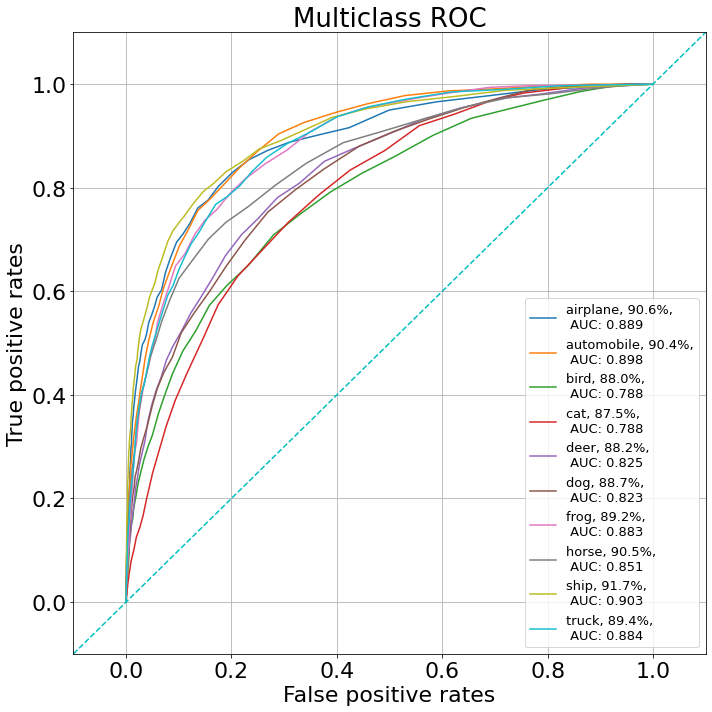

In [81]:
y_pred3 = RFC.predict(X_test)
y_pred_proba3 = RFC.predict_proba(X_test)
print(y_pred3.shape, y_pred_proba2.shape)
ROC_curves(y_test,y_pred3,y_pred_proba3)

Seems like it actually has some great accuracy, but these curves seems to be somewhat strange. As far as I can remember, I disgussed this with the corrector at HW8, that these tree models **cannot be allowed to fully grow as they lose their probabilistic property**.

## 4. Train an multi layer perceptron classifier

* use the `MLPClassifier` from `sklearn`
* Set its parameter to `max_iter = 30` or if you have time, set it for at least `100`. After `30` iterations the model does not converge but gives reasonable predictions (with default parameters).
* Plot the ROC curves with AUC scores for the test set.
* Calculate the accuracy of the model on the test set.



In [82]:
from sklearn.neural_network import MLPClassifier

In [84]:
MLPC = MLPClassifier(activation="tanh",max_iter=45)
MLPC.fit(X_train, y_train.flatten())

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(activation='tanh', max_iter=45)

(10000,) (10000, 10)
Vals: found (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([ 911, 1276, 1003,  944, 1116,  892, 1181,  866,  760, 1051]))


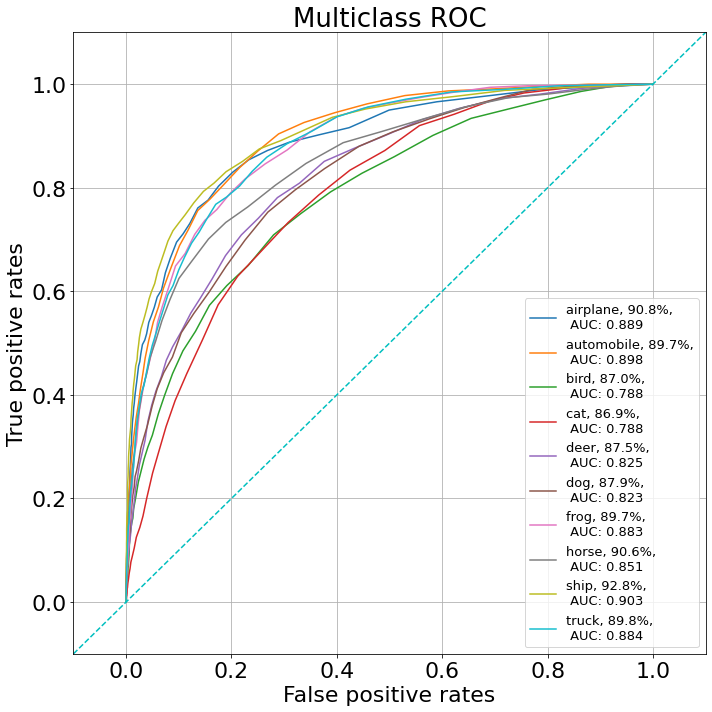

In [85]:
y_pred4 = MLPC.predict(X_test)
y_pred_proba4 = RFC.predict_proba(X_test)
print(y_pred4.shape, y_pred_proba4.shape)
ROC_curves(y_test,y_pred4,y_pred_proba4)

Nerual Network and it reaches the accuracy of the Log. Res. model. There are other activation layer types...

## 5. Train a ResNet50 CNN model on the dataset, utilize pre-trained weights and fine-tune for at least 3 epochs:

**NOTE: for some reason, the model has succeded to be made, but google colab collapsed on me...**

* training for 3 epochs should be enough to prove that this model is superior compared to others, train longer and you'll see exceptional results

Convert the dataset:

```python
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(32)
```

Hints:

* loading a pretrained model and letting its parameters be tunable

```python
backbone = tf.keras.applications.YOUR_MODEL_OF_CHOICE
backbone.trainable = True # DO NOT FORGET TO UNFREEZE IT
```

* defining your custom model with the pretrained backbone

```python
# YOUR_MODEL_OF_CHOICE here is ResNet50 (!) as described in the task description.

# Functional TensorFlow API
def my_own_model():
  input_placeholder = tf.keras.layers.Input(shape=(32, 32, 3))
  # DO NOT FORGET THE PROPER INPUT PREPROCESSING FOR THE BACKBONE
  x = tf.keras.applications.YOUR_MODEL_OF_CHOISE.preprocess_input(PROPER_INPUT)
  # PLEASE USE THE PROPER INPUT: (e.g. 8 bit input)
  x = backbone(x)
  # Here comes some more layers
  # and flattening at the end if needed!
  out = # layer outputting the specified number of classes
        # with or without a softmax activation, later on
        # the choice of the loss depends on this
  model = tf.keras.models.Model(inputs=inp, outputs=out)
  return model
```

Some source for me to understand it: https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691

In [5]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [ ]:
#i was using the starndar scaled data and now i convert it back
y_train_oh = tf.keras.utils.to_categorical(y_train,10)
y_test_oh = tf.keras.utils.to_categorical(y_test,10)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_oh))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_oh))
test_dataset = test_dataset.batch(32)

In [39]:
#this needed sme heavy modifications

# Functional TensorFlow API
def my_own_model(nm ='ResNet50'):


  inp= tf.keras.layers.Input(shape=(32, 32, 3), name='input')  #original pics are needed
  # tf.cast(i,tf.uint32)

  #if i leave this outside, the input  tensor should be initialized there...
  backbone = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=inp)
  backbone.trainable = True # DO NOT FORGET TO UNFREEZE IT

  # DO NOT FORGET THE PROPER INPUT PREPROCESSING FOR THE BACKBONE
  x = tf.keras.applications.resnet50.preprocess_input(inp)

  x = backbone(x)
  """
  x = Flatten()(x)
  x = BatchNormalization()(x)

  x = Conv2D(16, kernel_size=(3, 3), padding='valid', activation='relu')(x)
  x = Conv2D(16, kernel_size=(3, 3), padding='valid', activation='relu')(x)
  x = MaxPooling2D((2, 2))(x)

  x = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(x)
  x = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2))(x)
  """

  #x = Flatten()(x)
  x = Conv2D(256, kernel_size=(1, 1), padding='valid', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(256, kernel_size=(1, 1), padding='valid', activation='relu')(x)
  x = BatchNormalization()(x)

  x = tf.keras.layers.Flatten()(x)

  out = tf.keras.layers.Dense(units=10,
                              activation='softmax')(x)
  
  model = tf.keras.models.Model(inputs=inp, outputs=out,name=nm)
  return model

In [40]:
Zenobia = my_own_model()

In [134]:
with tf.device('/device:GPU:0'):
  Zenobia.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0),
                metrics=['accuracy'])
Zenobia.summary()

Model: "init_me"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 tf_op_layer_strided_slice_1  [(None, 32, 32, 3)]      0         
  (TensorFlowOpLayer)                                            
                                                                 
 tf_op_layer_BiasAdd_1 (Tens  [(None, 32, 32, 3)]      0         
 orFlowOpLayer)                                                  
                                                                 
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 final (Dense)               (None, 10)                10010     
                                                                 
Total params: 25,646,722
Trainable params: 25,593,602
Non-t

The batch size seems to be somewhat critical in in convergence: with an n=batch_size with the dataset lenght N, n $\cdot$ ln(n) = N should be a good candidate for choosing the batchsize

In [152]:
with tf.device('/device:GPU:0'):
    history = Zenobia.fit(x=np.array(X_train*255, dtype=np.uint8).reshape(50000,32,32,3),
                                y=y_train_oh,                                    #needs one-hot encoded
                                batch_size=32,                                  #big, but not too big batches
                                validation_data=(np.array(X_test*255, dtype=np.uint8).reshape(10000,32,32,3), y_test_oh),             #technically this is wrong as i should separate it from train
                                epochs=3,                                        #3 epoch is wanted, but it seems like its not enough
                                verbose=1,
                                shuffle=True,                                    #some level of randomness
                                initial_epoch=0)

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 306s 6ms/sample - loss: 1.5974 - accuracy: 0.4128 - val_loss: 1.6665 - val_accuracy: 0.3906
Epoch 2/3
50000/50000 [==============================] - 306s 6ms/sample - loss: 1.4668 - accuracy: 0.4638 - val_loss: 1.6573 - val_accuracy: 0.4124
Epoch 3/3
50000/50000 [==============================] - 305s 6ms/sample - loss: 1.5728 - accuracy: 0.4272 - val_loss: 2.4666 - val_accuracy: 0.1326
